In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score , confusion_matrix

import itertools

In [2]:
# from google.colab import drive
drive.mount('/content/drive/Shareddrives/CIDL_Project', force_remount=True)
drive.mount('/content/drive', force_remount=True)

# print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-09-12 16:45:11.959905: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-12 16:45:12.548703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-12 16:45:12.548919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [ ]:
PATH = os.path.join(os.getcwd(), 'drive', 'Shareddrives', 'CIDL_Project')

dataPath = os.path.join(PATH, 'dataset')

scratchPath = os.path.join(PATH, 'models', 'from_scratch')

fExtractorPath = os.path.join(PATH, 'models', 'feature_extraction')

fineTunedPath = os.path.join(PATH, 'models', 'fine_tuned')

print(dataPath)
print(scratchPath)
print(fExtractorPath)
print(fineTunedPath)

In [8]:
BATCH_SIZE = 32
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

# Dataset

In [4]:
diseases = os.listdir(os.path.join(dataPath, "train"))
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(os.path.join(dataPath, "train", disease)))
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

no. of images
Strawberry___healthy                                         1824
Tomato___healthy                                             1926
Tomato___Septoria_leaf_spot                                  1745
Cherry_(including_sour)___healthy                            1826
Potato___healthy                                             1824
Peach___Bacterial_spot                                       1838
Grape___Black_rot                                            1888
Tomato___Tomato_mosaic_virus                                 1790
Tomato___Leaf_Mold                                           1882
Strawberry___Leaf_scorch                                     1774
Tomato___Late_blight                                         1851
Corn_(maize)___healthy                                       1859
Squash___Powdery_mildew                                      1736
Tomato___Early_blight                                        1920
Grape___healthy                                              1692
Cherry_(including_sour)___Powdery_mildew                     1683
Pepper,_bell___healthy                                       1988
Peach___healthy                                              1728
Tomato___Tomato_Yellow_Leaf_Curl_Virus                       1961
Apple___healthy                                              2008
Potato___Late_blight                                         1939
Corn_(maize)___Northern_Leaf_Blight                          1908
Pepper,_bell___Bacterial_spot                                1913
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                   1722
Raspberry___healthy                                          1781
Apple___Cedar_apple_rust                                     1760
Corn_(maize)___Common_rust_                                  1907
Soybean___healthy                                            2022
Tomato___Bacterial_spot                                      1702
Potato___Early_blight                                        1939
Grape___Esca_(Black_Measles)                                 1920
Tomato___Target_Spot                                         1827
Apple___Apple_scab                                           2016
Apple___Black_rot                                            1987
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot           1642
Tomato___Spider_mites Two-spotted_spider_mite                1741
Orange___Haunglongbing_(Citrus_greening)                     2010
Blueberry___healthy                                          1816

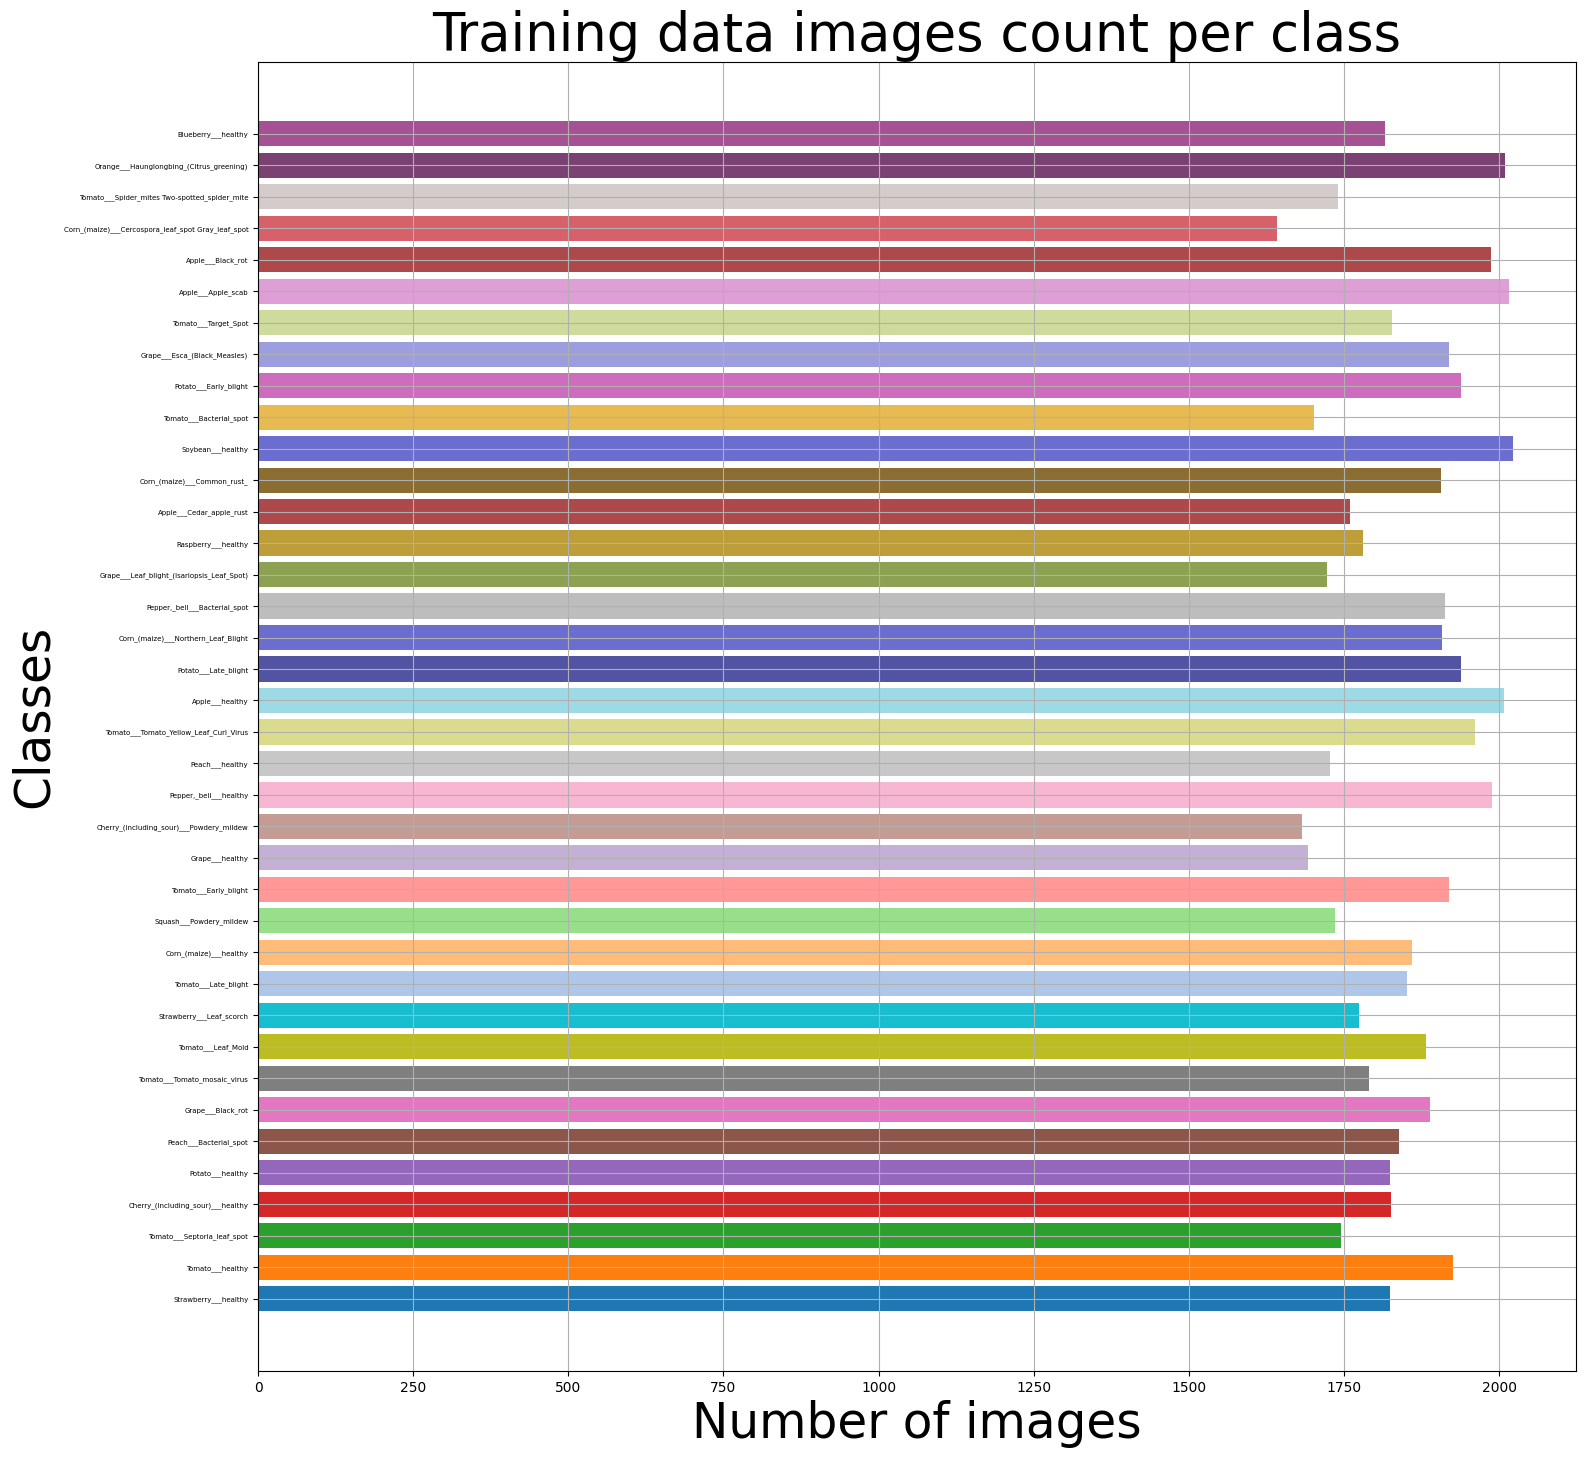

In [6]:
colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#d4cbcb", "#7b4173", "#a55194", "#ce6dbd"
]

index = [n for n in range(38)]

plt.figure(figsize=(17,17))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.yticks(index, diseases, fontsize=5, rotation=0)
plt.barh(index, [n for n in nums.values()], color=colors)
plt.grid(True)
plt.show()

In [41]:
train_dataset = keras.utils.image_dataset_from_directory(
    os.path.join(dataPath, 'train'),
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE,
    label_mode = 'categorical'
)

valid_dataset = keras.utils.image_dataset_from_directory(
    os.path.join(dataPath, 'valid'),
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE,
    label_mode = 'categorical'
)

test_dataset = keras.utils.image_dataset_from_directory(
    os.path.join(dataPath, 'test'),
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE,
    label_mode = 'categorical',
    shuffle=False
)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.
Found 5438 files belonging to 38 classes.


# Data Augmentation

In [9]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"), # Applies horizontal flipping to a random 50% of the images
  layers.RandomRotation(0.1), # Rotates the input images by a random value in the range[–10%, +10%] (fraction of full circle [-36°, 36°])
  layers.RandomZoom(0.1), # Zooms in or out of the image by a random factor in the range [-20%, +20%]
  layers.RandomContrast(0.1),
],
name = "AugmentationLayer"
)

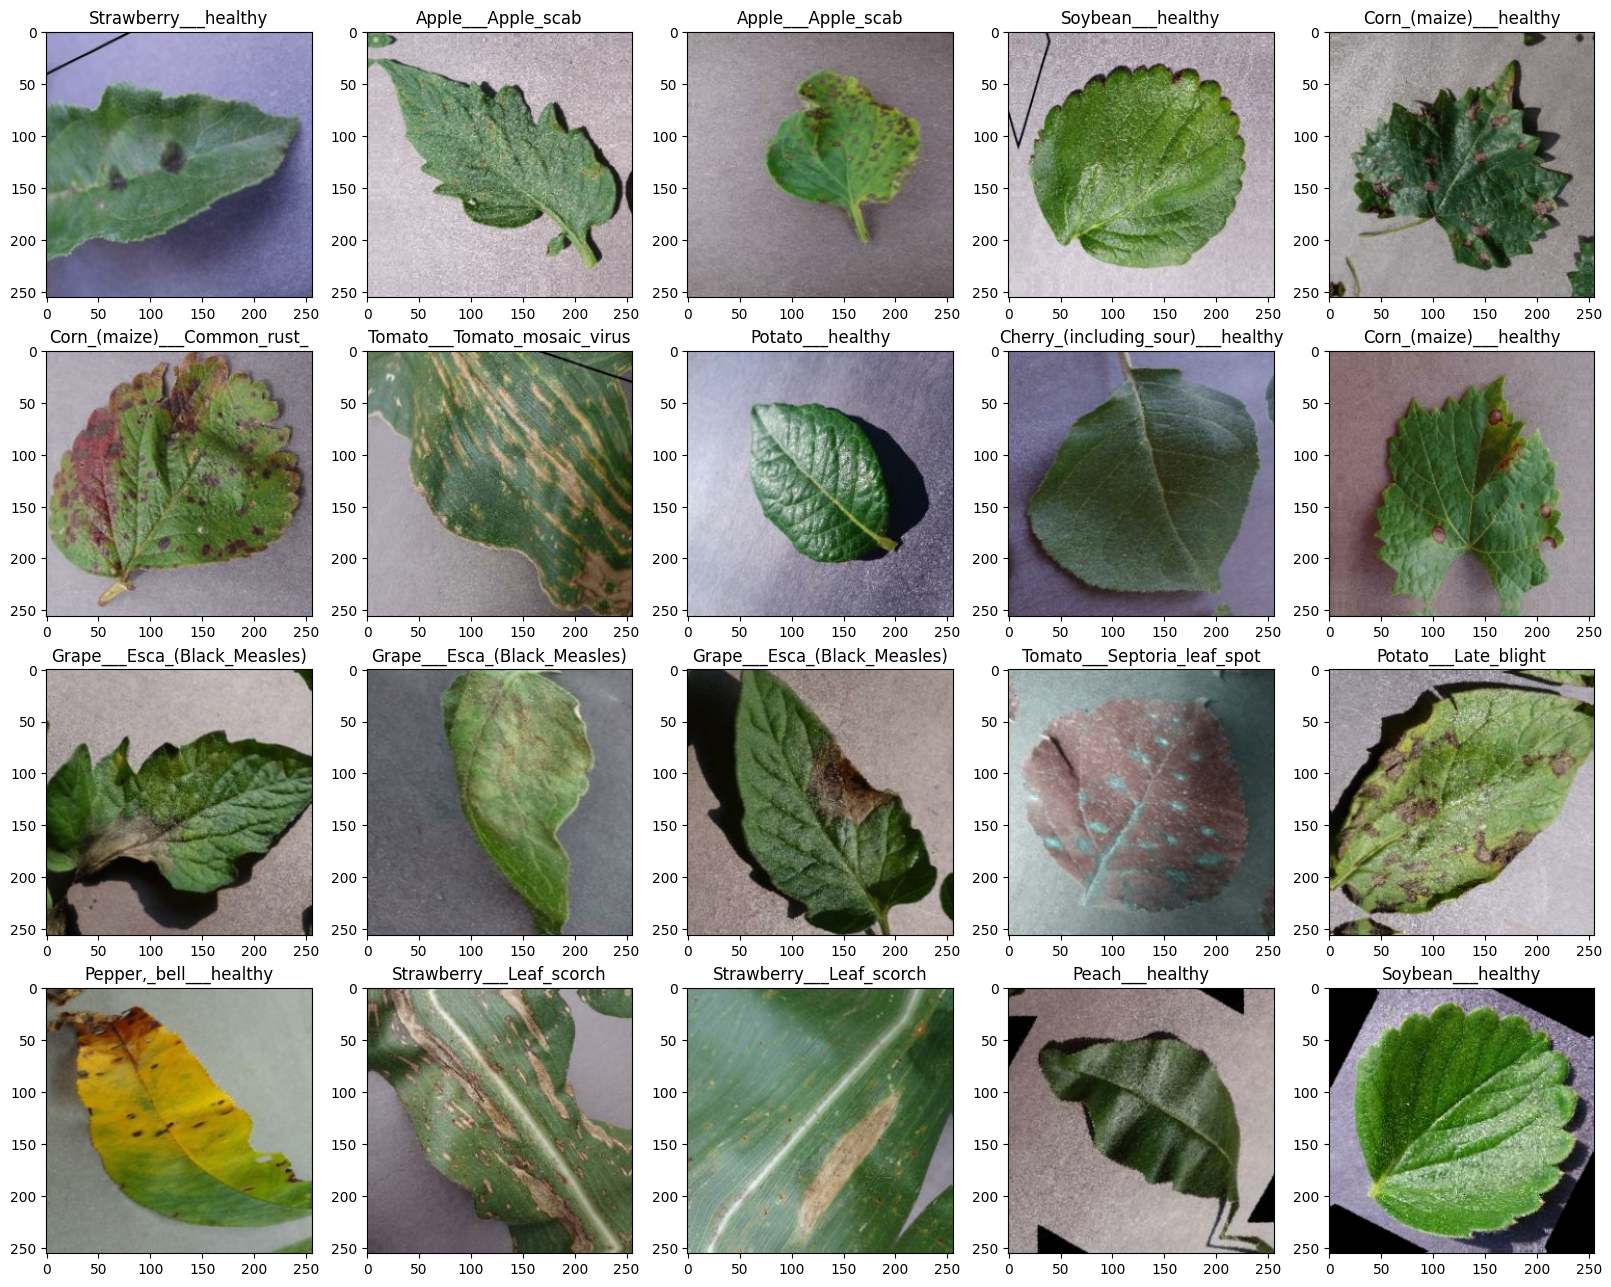

In [10]:
plt.figure(figsize=(20, 20))
for images, y_batch in train_dataset.take(1):
    for i in range(20):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title(diseases[np.where(y_batch[i]==1)[0][0]])

# From scratch model

In [ ]:
from tensorflow.keras import models

model = keras.Sequential(name="FromScratch")
model.add(data_augmentation)
model.add(layers.Rescaling(1./255)) 

model.add(layers.Conv2D(32, kernel_size = 3, activation = "relu6", padding = "same", input_shape = (256, 256,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, kernel_size = 3, activation='relu', padding = "same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, kernel_size = 3, activation='relu', padding = "same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, kernel_size = 3, activation='relu', padding = "same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(512, kernel_size = 3, activation='relu', padding = "same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(512, kernel_size = 3, activation='relu', padding = "same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256,activation="relu"))
model.add(layers.Dense(38,activation="softmax"))

model.build(input_shape=(None, 256, 256, 3))

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model.summary()

In [15]:
modelName = "32relu6_64_128_256_512_512_Drp_256d"
modelPath = os.path.join(scratchPath, modelName + ".keras")

save_best_model = tf.keras.callbacks.ModelCheckpoint(modelPath, verbose=True, monitor='val_loss', save_best_only=True, save_weights_only=True)

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset,
    validation_steps=len(valid_dataset),
    callbacks=[earlyStopping, save_best_model]
  )

Epoch 1/20


2197/2197 [==============================] - ETA: 0s - loss: 0.9826 - accuracy: 0.7176
Epoch 1: val_loss improved from inf to 1.89372, saving model to /home/chuck/Documents/Project/models/from_scratch/32relu6_64_128_256_512_512_Drp_256d.keras
2197/2197 [==============================] - 389s 175ms/step - loss: 0.9826 - accuracy: 0.7176 - val_loss: 1.8937 - val_accuracy: 0.6201
Epoch 2/20
2197/2197 [==============================] - ETA: 0s - loss: 0.3943 - accuracy: 0.8775
Epoch 2: val_loss improved from 1.89372 to 0.86715, saving model to /home/chuck/Documents/Project/models/from_scratch/32relu6_64_128_256_512_512_Drp_256d.keras
2197/2197 [==============================] - 384s 175ms/step - loss: 0.3943 - accuracy: 0.8775 - val_loss: 0.8671 - val_accuracy: 0.7749
Epoch 3/20
2197/2197 [==============================] - ETA: 0s - loss: 0.2718 - accuracy: 0.9146
Epoch 3: val_loss improved from 0.86715 to 0.47868, saving model to /home/chuck/Documents/Project/models/from_scratch/32relu6_6

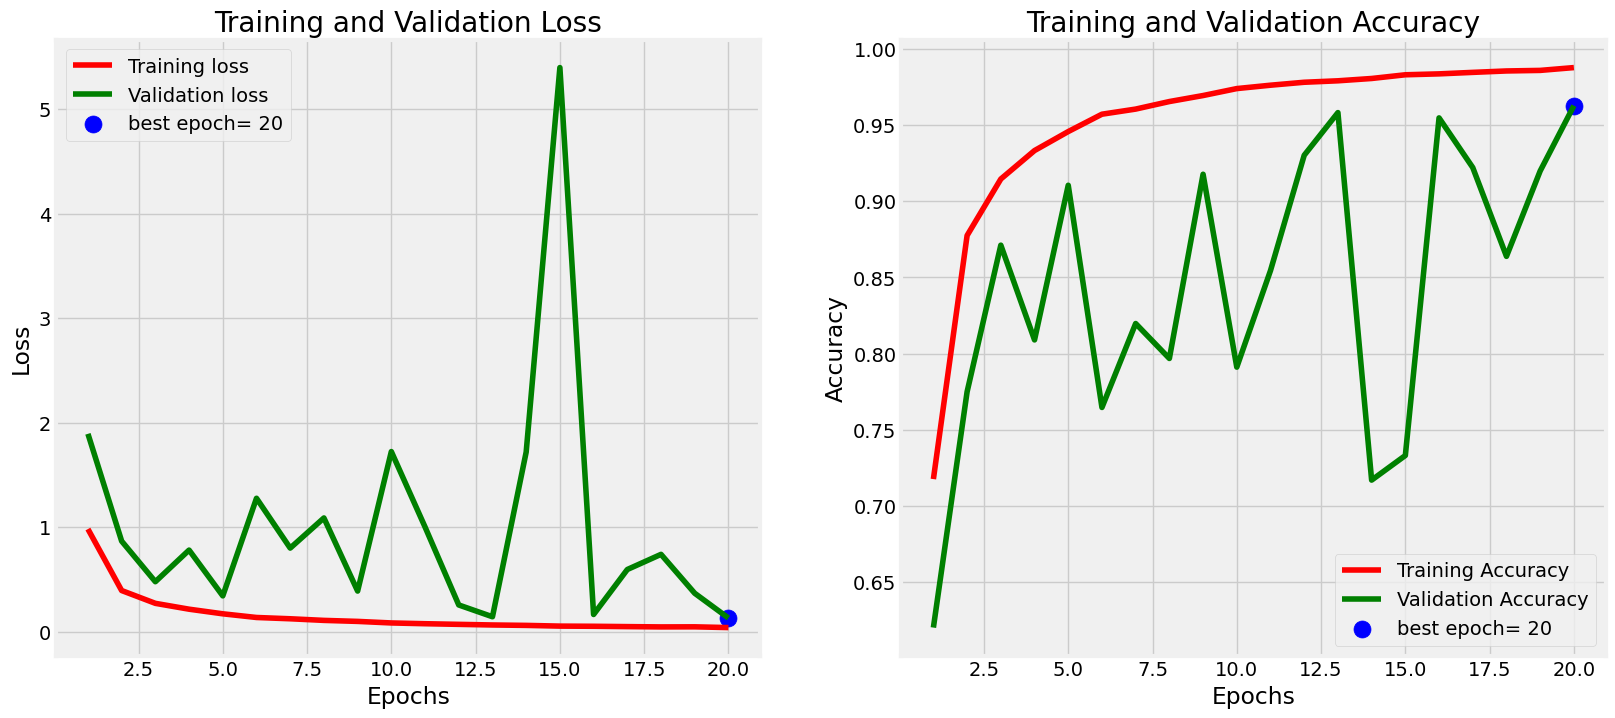

* 32relu6_64_128_256_512_512_Drp_256d | val_loss: 0.1311 | val_accuracy: **0.9627**



In [16]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout

# plt.savefig(os.path.join(imgPath, "scratch", modelName))
plt.show()

text_to_add = "* " + modelName + " | val_loss: " + "{:.4f}".format(val_lowest) + " | val_accuracy: **" + "{:.4f}".format(val_acc[index_loss]) + "**\n"
print(text_to_add)

# Feature extraction
Used model: VGG16


In [25]:
cnn_base = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
    pooling='max',
)
cnn_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
  layers.Rescaling(1./255)
])

cnn_base.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', sum(np.prod(x.shape) for x in cnn_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [27]:
pretrained_model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    cnn_base,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(38, activation = 'softmax')
])


pretrained_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ["accuracy"]
)

pretrained_model.build(input_shape=(None, IMAGE_HEIGHT, IMAGE_WIDTH, 3))

pretrained_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 AugmentationLayer (Sequent  (None, 256, 256, 3)       0         
 ial)                                                            
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_8 (Bat  (None, 256)               1024      
 chNormalization)                                     

In [24]:
modelName = "FE_base_256d"
modelPath = os.path.join(fExtractorPath, modelName + ".keras")

save_best_model = tf.keras.callbacks.ModelCheckpoint(modelPath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=True)

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = pretrained_model.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset,
    validation_steps=len(valid_dataset),
    callbacks=[earlyStopping, save_best_model]
  )

Epoch 1/20


2023-09-09 19:44:59.956793: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-09 19:45:02.991876: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-09 19:45:02.991944: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2196/2197 [============================>.] - ETA: 0s - loss: 0.8083 - accuracy: 0.7582

2023-09-09 19:55:34.038381: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-09 19:55:34.533007: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-09 19:55:34.533073: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2197/2197 [==============================] - ETA: 0s - loss: 0.8082 - accuracy: 0.7582
Epoch 1: val_loss improved from inf to 0.60236, saving model to /home/chuck/Documents/Project/models/feature_extraction/FE_base_256d.keras
2197/2197 [==============================] - 789s 354ms/step - loss: 0.8082 - accuracy: 0.7582 - val_loss: 0.6024 - val_accuracy: 0.8109
Epoch 2/20
2197/2197 [==============================] - ETA: 0s - loss: 0.5447 - accuracy: 0.8241
Epoch 2: val_loss improved from 0.60236 to 0.40663, saving model to /home/chuck/Documents/Project/models/feature_extraction/FE_base_256d.keras
2197/2197 [==============================] - 775s 353ms/step - loss: 0.5447 - accuracy: 0.8241 - val_loss: 0.4066 - val_accuracy: 0.8701
Epoch 3/20
2197/2197 [==============================] - ETA: 0s - loss: 0.5169 - accuracy: 0.8325
Epoch 3: val_loss did not improve from 0.40663
2197/2197 [==============================] - 774s 352ms/step - loss: 0.5169 - accuracy: 0.8325 - val_loss: 0.4986 

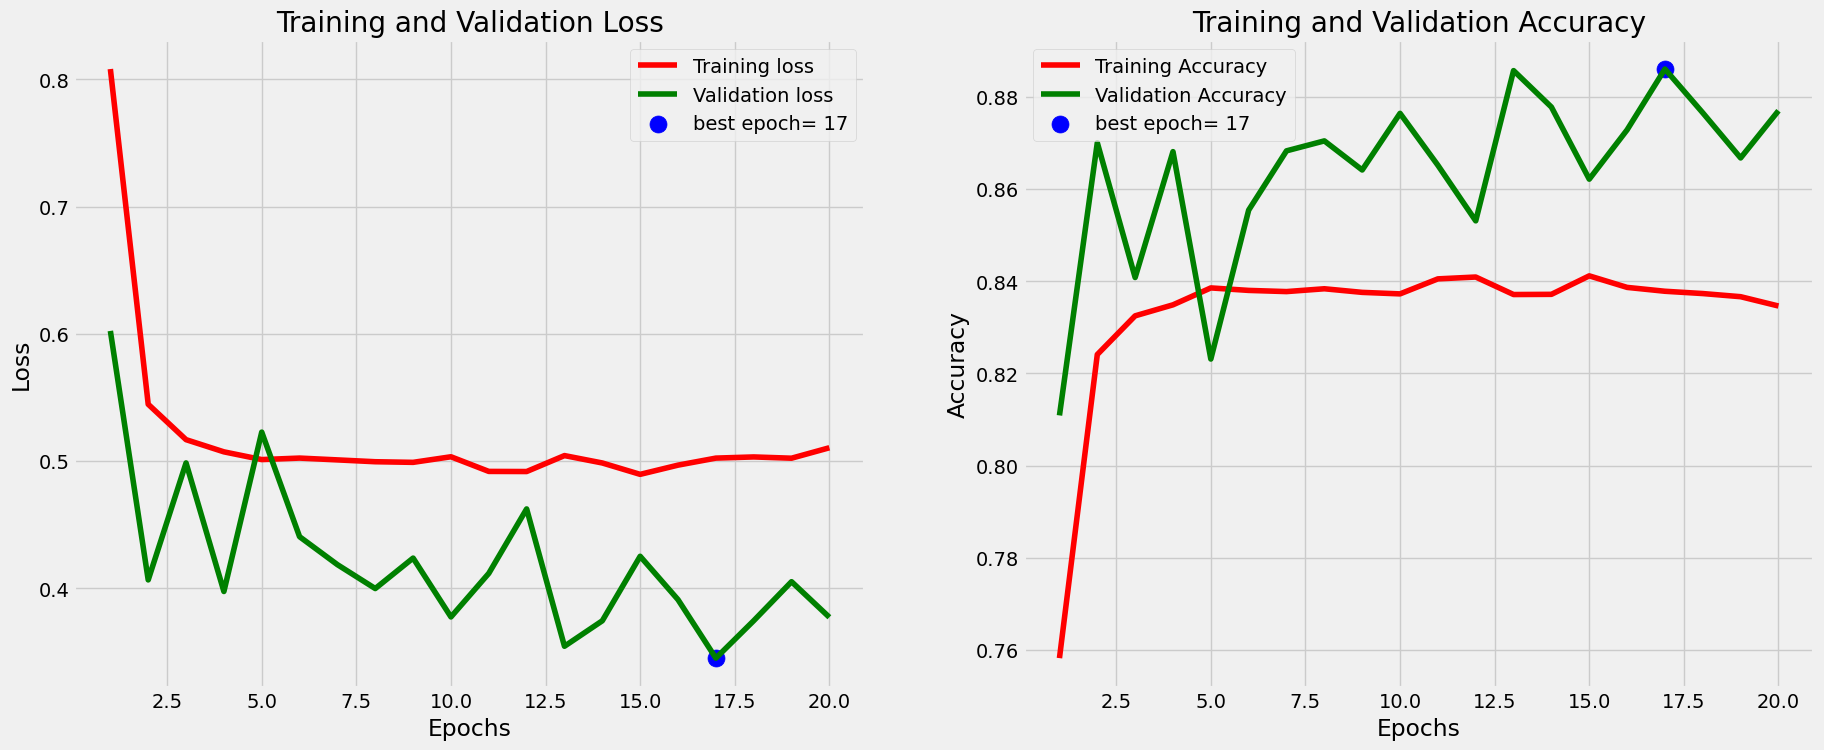

* FE_base_256d | val_loss: 0.3451 | val_accuracy: **0.8861**



In [25]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout

# plt.savefig(os.path.join(imgPath, "FExtraction", modelName))
plt.show()

text_to_add = "* " + modelName + " | val_loss: " + "{:.4f}".format(val_lowest) + " | val_accuracy: **" + "{:.4f}".format(val_acc[index_loss]) + "**\n"
print(text_to_add)


# Fine Tuning

In [28]:
cnn_base.trainable = True

set_trainable = False

for layer in cnn_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

cnn_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [15]:
pretrained_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics = ["accuracy"]
)

pretrained_model.build(input_shape=(None, IMAGE_HEIGHT, IMAGE_WIDTH, 3))

modelName = "FT_base_256d"
modelPath = os.path.join(fineTunedPath, modelName + ".keras")

save_best_model = tf.keras.callbacks.ModelCheckpoint(modelPath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=True)

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = pretrained_model.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset,
    validation_steps=len(valid_dataset),
    callbacks=[earlyStopping, save_best_model],
  )

Epoch 1/20


2023-09-10 16:57:55.309117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-09-10 16:57:55.697143: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-10 16:57:56.716732: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-10 16:57:59.644636: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-10 16:57:59.644708: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate

2196/2197 [============================>.] - ETA: 0s - loss: 0.3535 - accuracy: 0.8861

2023-09-10 17:09:02.963166: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-10 17:09:03.543243: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-10 17:09:03.543323: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2197/2197 [==============================] - ETA: 0s - loss: 0.3535 - accuracy: 0.8861
Epoch 1: val_loss improved from inf to 0.17523, saving model to /home/chuck/Documents/Project/models/fine_tuned/FT_base_256d.keras
2197/2197 [==============================] - 818s 365ms/step - loss: 0.3535 - accuracy: 0.8861 - val_loss: 0.1752 - val_accuracy: 0.9455
Epoch 2/20
2197/2197 [==============================] - ETA: 0s - loss: 0.2422 - accuracy: 0.9225
Epoch 2: val_loss improved from 0.17523 to 0.15053, saving model to /home/chuck/Documents/Project/models/fine_tuned/FT_base_256d.keras
2197/2197 [==============================] - 800s 364ms/step - loss: 0.2422 - accuracy: 0.9225 - val_loss: 0.1505 - val_accuracy: 0.9515
Epoch 3/20
2197/2197 [==============================] - ETA: 0s - loss: 0.1911 - accuracy: 0.9402
Epoch 3: val_loss improved from 0.15053 to 0.12264, saving model to /home/chuck/Documents/Project/models/fine_tuned/FT_base_256d.keras
2197/2197 [==============================]

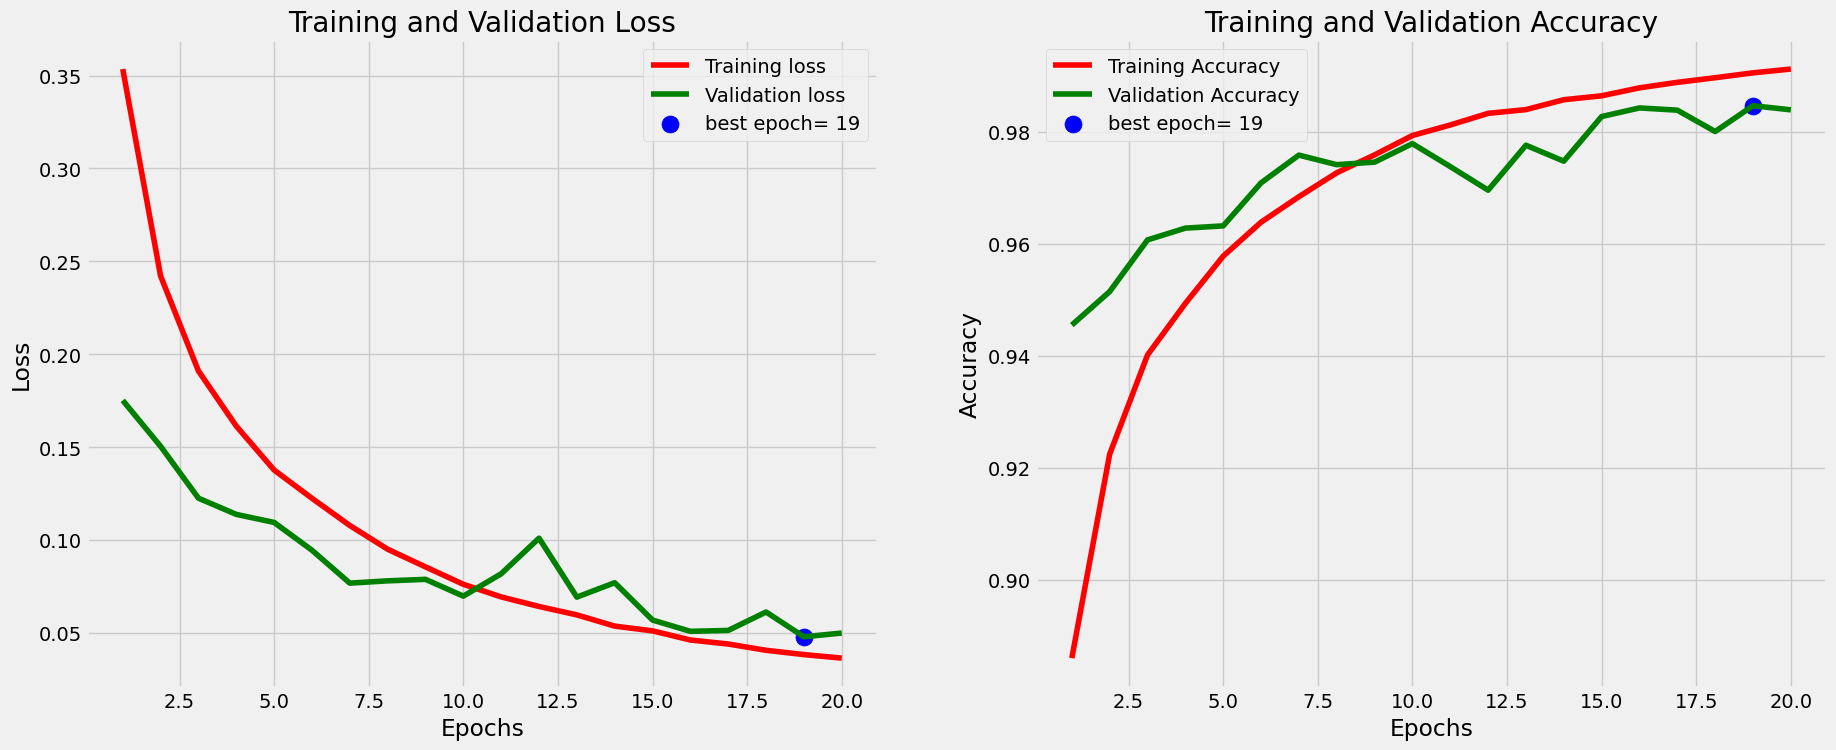

* FT_base_256d | val_loss: 0.0481 | val_accuracy: **0.9847**



In [17]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout

# plt.savefig(os.path.join(imgPath, "fine-tuning", modelName))
plt.show()

text_to_add = "* " + modelName + " | val_loss: " + "{:.4f}".format(val_lowest) + " | val_accuracy: **" + "{:.4f}".format(val_acc[index_loss]) + "**\n"
print(text_to_add)


# Comparison on the test set

In [49]:
# Recovery of the best model from scratch
scratchName = "32relu6_64_128_256_512_512_Drp_256d"
path = os.path.join(scratchPath, scratchName + ".keras")

model.load_weights(path)

# Recovery of the best model fine-tuned
fTunedName = "FT_base_256d"
path = os.path.join(fineTunedPath, fTunedName + ".keras")

pretrained_model.load_weights(path)

In [45]:
# Create an empty list to store the labels
labels_list = []

# Iterate through the dataset using a for loop
for data_item, label in test_dataset:
    labels_list.extend(np.argmax(label.numpy(), axis=1))  # Append the label to the list

# Now, labels_list contains all the labels in the test_dataset
print(len(labels_list))

5438


## From scratch

### Accuracy

In [50]:
results = model.evaluate(test_dataset, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.08954
Test Accuracy: 97.59%


### Confusion Matrix

 89/170 [==============>...............] - ETA: 3s

170/170 [==============================] - 7s 39ms/step


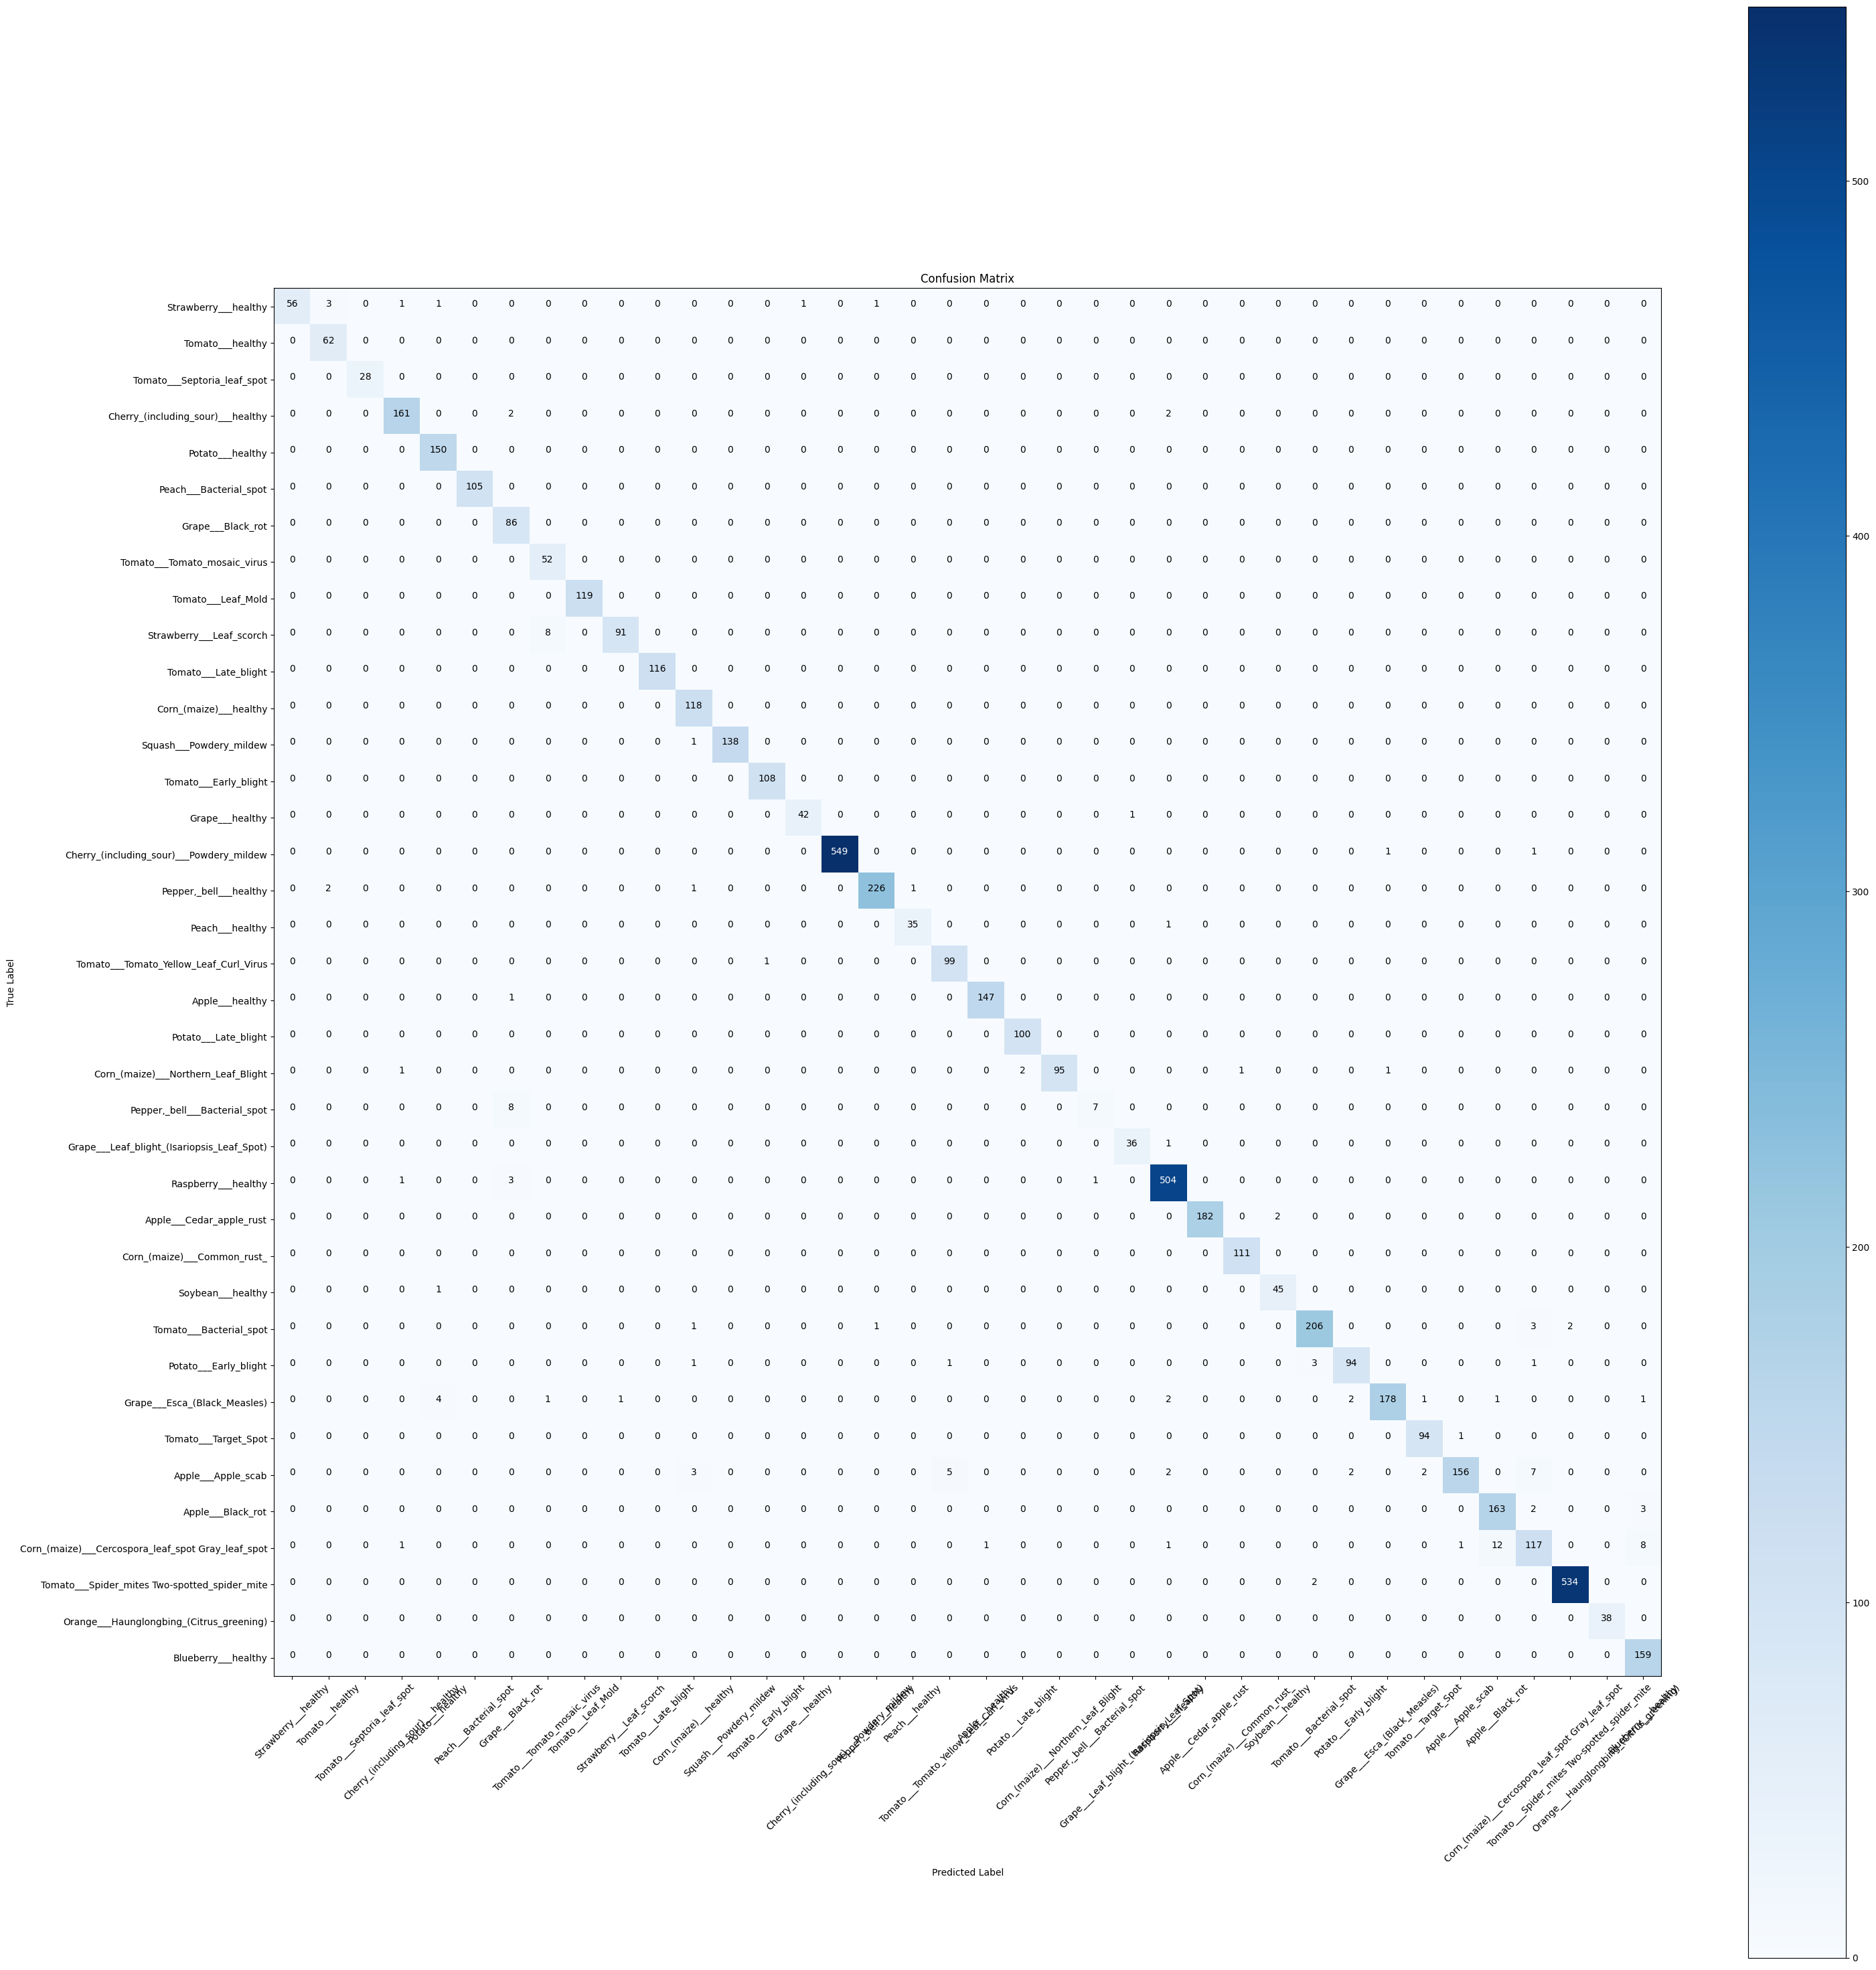

In [46]:
preds = model.predict(test_dataset)
y_pred = np.argmax(preds, axis=1)

# Confusion matrix
cm = confusion_matrix(labels_list, y_pred)

plt.figure(figsize= (30, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(diseases))
plt.xticks(tick_marks, diseases, rotation= 45)
plt.yticks(tick_marks, diseases)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

### F1 score

In [51]:
f1 = f1_score(labels_list, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(labels_list, y_pred, target_names=diseases))

F1 Score: 0.962158352503775
                                                    precision    recall  f1-score   support

                              Strawberry___healthy       1.00      0.89      0.94        63
                                  Tomato___healthy       0.93      1.00      0.96        62
                       Tomato___Septoria_leaf_spot       1.00      1.00      1.00        28
                 Cherry_(including_sour)___healthy       0.98      0.98      0.98       165
                                  Potato___healthy       0.96      1.00      0.98       150
                            Peach___Bacterial_spot       1.00      1.00      1.00       105
                                 Grape___Black_rot       0.86      1.00      0.92        86
                      Tomato___Tomato_mosaic_virus       0.85      1.00      0.92        52
                                Tomato___Leaf_Mold       1.00      1.00      1.00       119
                          Strawberry___Leaf_scorch 

## Fine-tuned

### Accuracy

In [52]:
results = pretrained_model.evaluate(test_dataset, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

2023-09-12 17:58:00.337488: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-12 17:58:02.676602: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-12 17:58:02.676664: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-12 17:58:42.481601: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

    Test Loss: 0.03156
Test Accuracy: 99.01%


### Confusion Matrix

 49/170 [=======>......................] - ETA: 25s

170/170 [==============================] - 35s 208ms/step


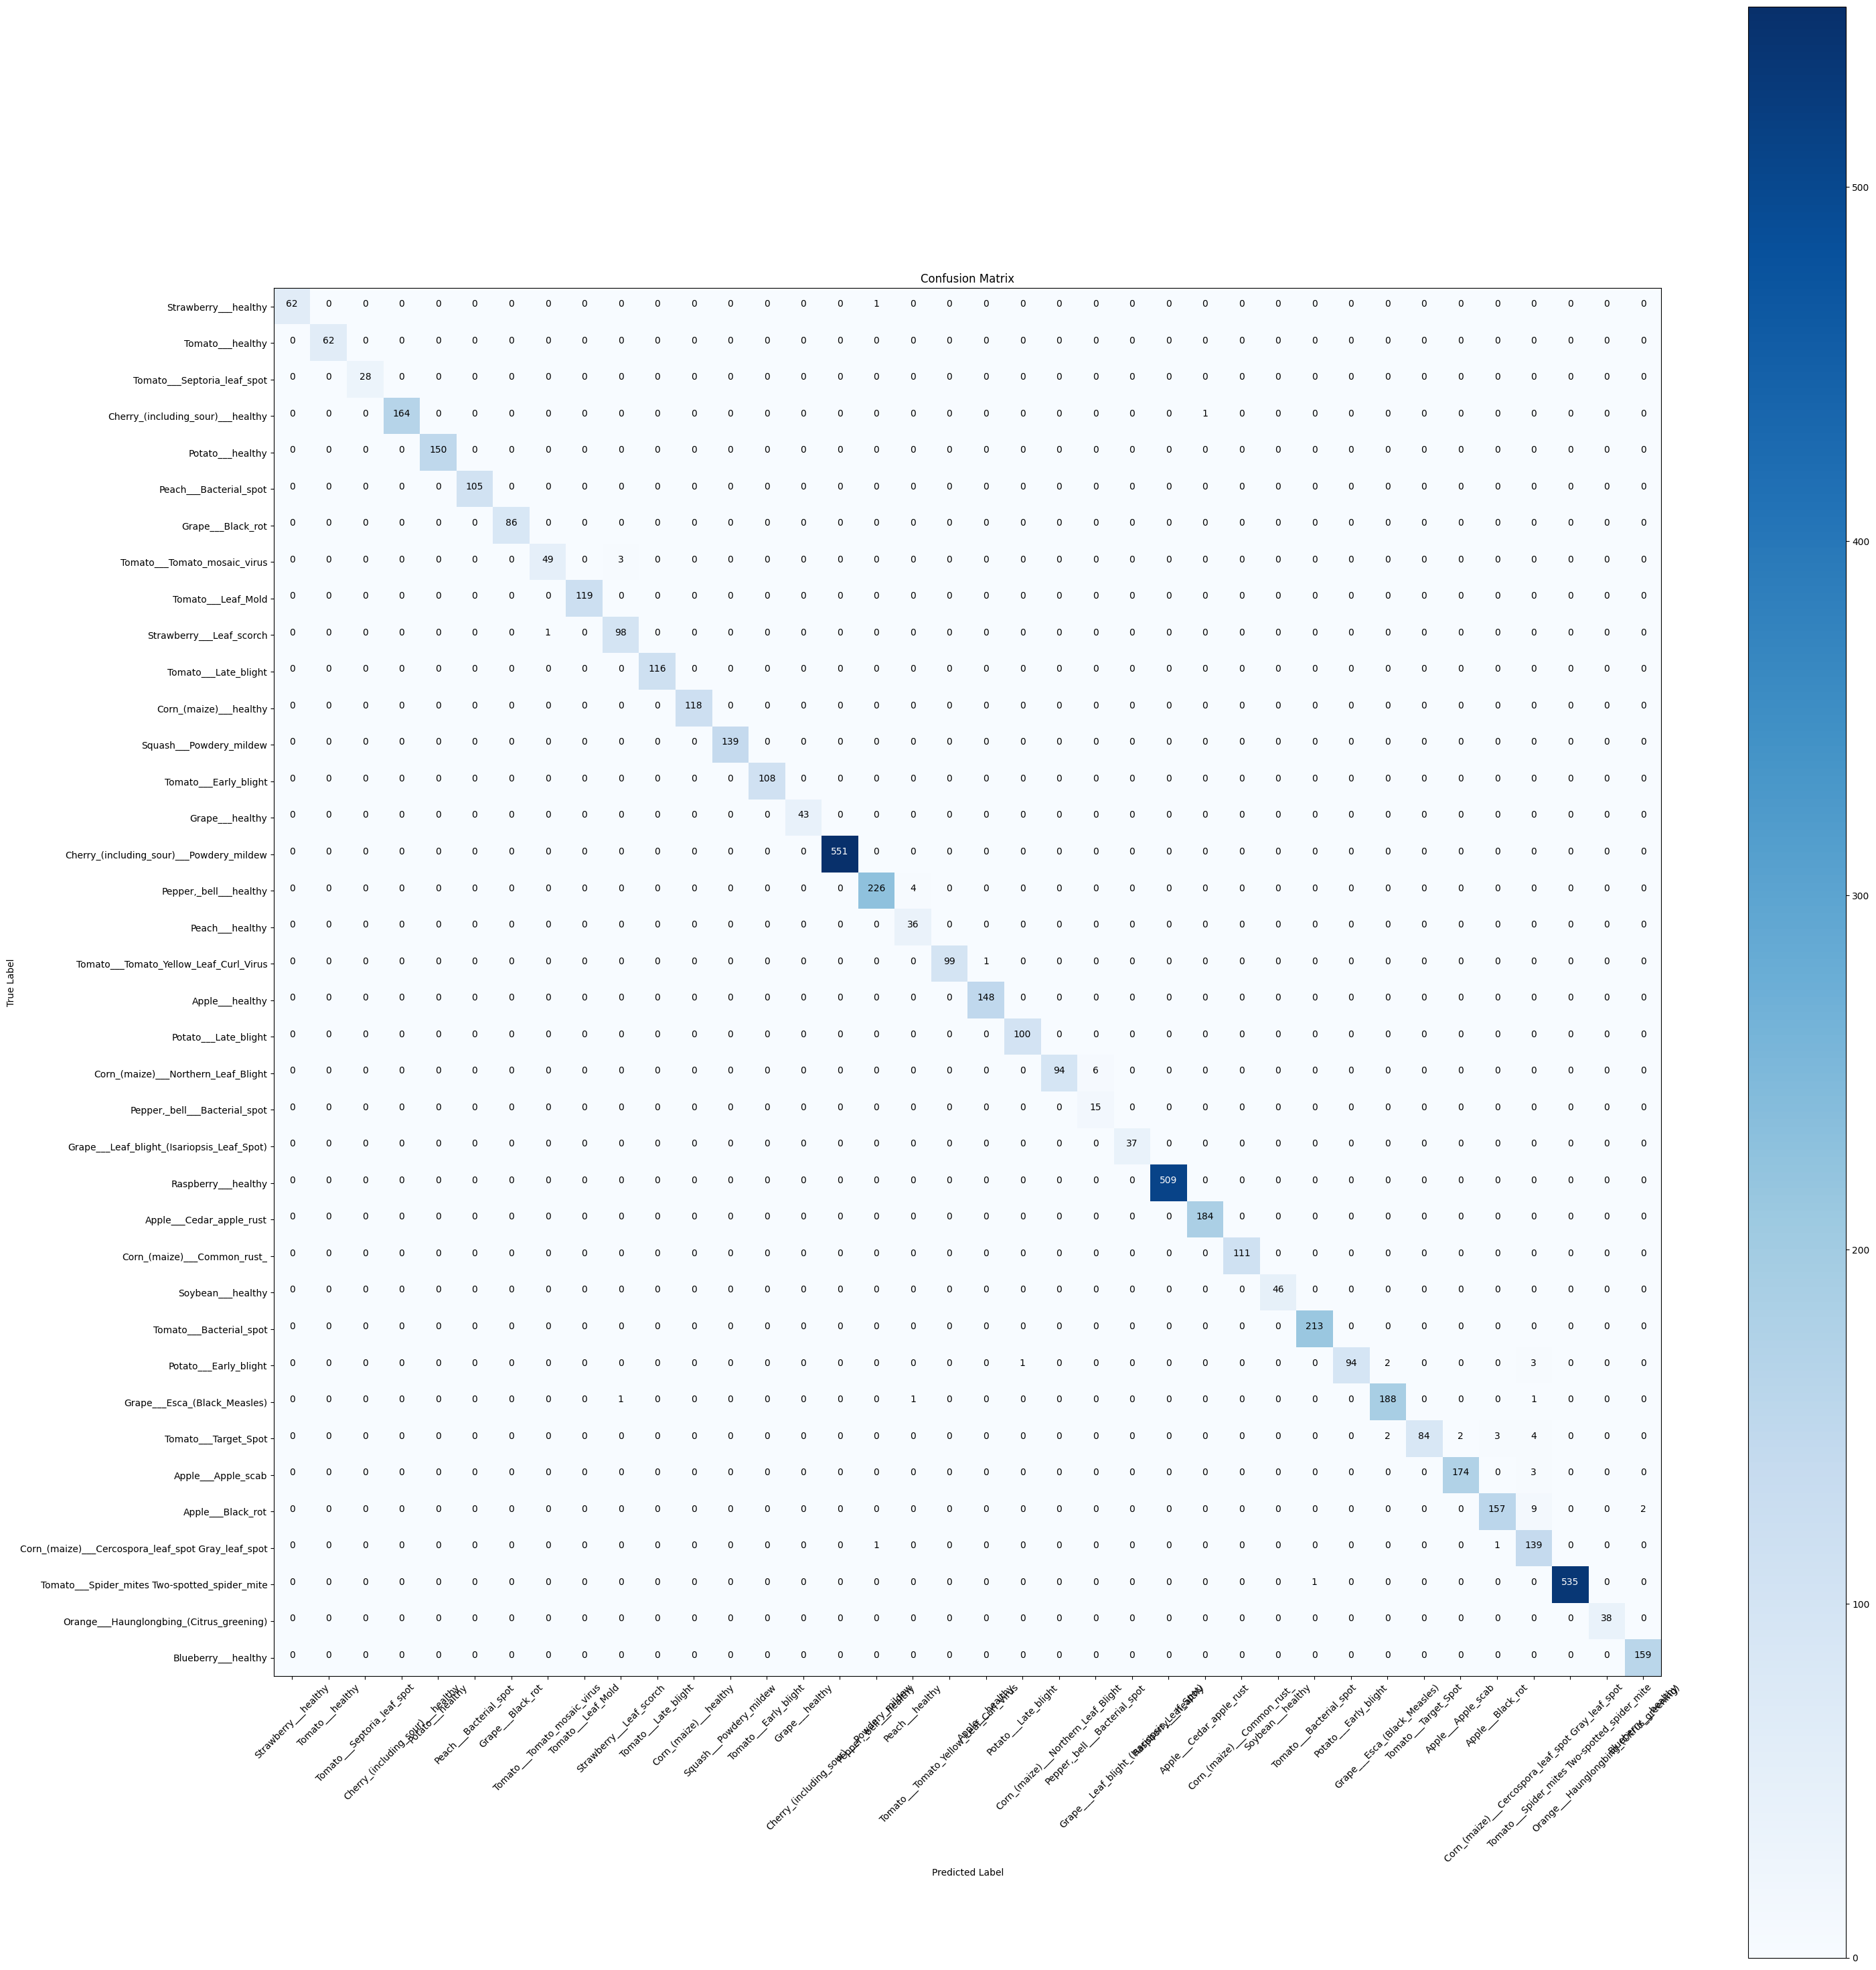

In [54]:
preds = pretrained_model.predict(test_dataset)
y_pred = np.argmax(preds, axis=1)

# Confusion matrix
cm = confusion_matrix(labels_list, y_pred)

plt.figure(figsize= (30, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(diseases))
plt.xticks(tick_marks, diseases, rotation= 45)
plt.yticks(tick_marks, diseases)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

### F1 score

In [55]:
f1 = f1_score(labels_list, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(labels_list, y_pred, target_names=diseases))

F1 Score: 0.9836812845075977
                                                    precision    recall  f1-score   support

                              Strawberry___healthy       1.00      0.98      0.99        63
                                  Tomato___healthy       1.00      1.00      1.00        62
                       Tomato___Septoria_leaf_spot       1.00      1.00      1.00        28
                 Cherry_(including_sour)___healthy       1.00      0.99      1.00       165
                                  Potato___healthy       1.00      1.00      1.00       150
                            Peach___Bacterial_spot       1.00      1.00      1.00       105
                                 Grape___Black_rot       1.00      1.00      1.00        86
                      Tomato___Tomato_mosaic_virus       0.98      0.94      0.96        52
                                Tomato___Leaf_Mold       1.00      1.00      1.00       119
                          Strawberry___Leaf_scorch